In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import seaborn as sns
from misc.utils import get_mean_norm, log_to_lin, lin_to_log, generate_test_data, get_closest_values, load_df
from misc.iterators import data_iterators
from misc.MLP import MLP
from pytorch_lightning import utilities

utilities.seed.seed_everything(seed=0, workers=True)

Global seed set to 0


0

In [5]:
def compare_with_data(P, K, T, datapath, dataset, model, include_data):
    if include_data:
        df = load_df(datapath, dataset, 'both')

        df = get_closest_values(df, P, K, T)
        df = df.sort_values(by='t', ascending=True)

        data_gam = df['gamma']
        t = df['t'].values
        X = df[['P', 'K', 'T', 't']].values
        P = df['P'].iloc[0]
        K = df['K'].iloc[0]
        T = df['T'].iloc[0]

        X = torch.tensor(X).type(torch.float)
        plt.plot(t, data_gam, label='data')

    else:
        X = generate_test_data(P, K, T)
        t = X[:, -1].clone()
        err = 0

    pred = model(X).detach().squeeze()

    if include_data:
        err = ((pred-data_gam)/data_gam).abs().mean()

    print(f"""
        P = {P}
        K = {K}
        T = {T}
    Error: {err*100:.2f}%
    """)

    plt.plot(t, pred, label='prediction')
    plt.xlabel(r'$\tau (fm)$')
    plt.ylabel(r'$d \Gamma / dK$')
    plt.legend()
    plt.show()



        P = 94.912
        K = 28.474
        T = 0.261
    Error: 1.73%
    


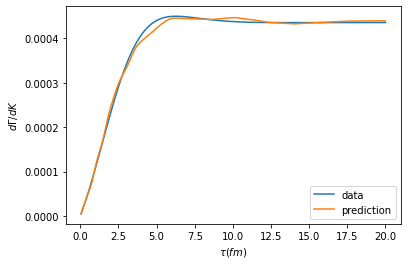

In [6]:
h_dim = 64
n_layers = 8
method = '0'
batch_size = 64
pc_err = "2.54e-02"

datafile = 'method_'+method+'.csv'
datapath = '../datasets'
results_dir = "../Results"
(_, _, test), consts_dict = data_iterators(
    datafile=datafile,
    datapath=datapath,
    batch_size=batch_size
    )

model_file = f'M_{method}_n_layers_{n_layers}_hid_dim_{h_dim}_val_pc_err={pc_err}.ckpt'
model_path = os.path.join(results_dir, "saved_models", f'Method_{method}', model_file)
model = MLP.load_from_checkpoint(
    checkpoint_path=model_path,
    hidden_dim=h_dim,
    n_layers=n_layers,
    consts_dict=consts_dict
    )

P = 100
K = 0.3
K *= P
T = 0.26
include_data = True

compare_with_data(P, K, T, datapath, datafile, model, include_data=include_data)

In [35]:
Ks = np.linspace(0.1, 0.9, 9, endpoint=True)
Ts =  np.linspace(0.05, 1, 10).round(3)
ts = np.logspace(np.log10(0.05), np.log10(20), 100).round(3)

# p_mean, p_norm = get_mean_norm(Ps)
T_mean, T_norm = get_mean_norm(Ts, log=False)
t_mean, t_norm = get_mean_norm(ts)

# print(p_mean, p_norm)
splits = 3
Ps = np.logspace(np.log10(5), 3, 10).round(3)
lin_spaced = np.log10(Ps)
# print(lin_spaced)
for i in range(splits):
    l2 = (lin_spaced[1:] + lin_spaced[:-1])/2
    lin_spaced = np.concatenate((lin_spaced, l2))
    lin_spaced = np.unique(lin_spaced)
    lin_spaced = np.sort(lin_spaced)
# print(lin_spaced)

# Ps = np.logspace(np.log10(5), 3, 20).round(3)
# print(Ps)
# print(log_to_lin(Ps, p_mean, p_norm))
# print(lin_to_log(log_to_lin(Ps, p_mean, p_norm), p_mean, p_norm))
# print(ts)